# Analysis of a bike share network using machine learning
##### This notebook contains data extraction and transformation steps implemented in R, to which a machine learning model is fit.

J. Michael Shockley 

18 February 2019

For a public bike share service to function smoothly, bikes and docks at which to anchor them need to be available at stations throughout the network. When popular stations run out of bikes or fill up with them, the functionality of the entire bike share network is decreased. Redistribution of bikes between stations alleviates this issue, yet the redistribution process is expensive and labor intensive. An important logistics problem arises out of predicting which stations that will gain or lose bicycles. A multitude of factors may influence the usage of a public bike share service, and these are no doubt interconnected: geographic location of a station, weather, time of day, day of the week, etc.

The goal of this project was to take several well-known data sets of a San Francisco Bay Area bike share company and examine the relationships between trip-by-trip usage data, daily weather conditions, and information about the stations themselves. A year's worth of data from a time period of 09/2014 to 08/2015 helped to build a model predicting hourly rate of change per station.

Given data on the stations, usage, and weather during the time period of Sept. 2014 to Aug. 2015, the company wishes to build a predictive model to estimate the change in bicycles at a given station in the next hour. The following analysis was written in R making use of the caret and glmnet machine learning packages.
## Data exploration
Three files were provided: trip_data.csv, weather_data.csv, and station_data.csv. The trip data file includes a unique trip ID, the start and end date/time of each trip, the corresponding start and end station of each trip, and the subscriber type. The weather data contains various metrics of the weather including total precipitation, cloud cover, wind direction, maximum/mean/mininum temperature, dew point, relative humidity, visibility, and wind speed, and stated weather events for each zip code in which the bike share system operates. The station data contains the station ID, name, geographic location, and number of docks for each bike station.

In [1]:
library(dplyr)
library(tidyverse)
TD<-read.csv("trip_data.csv", header=TRUE, blank.lines.skip=FALSE)
WD<-read.csv("weather_data.csv", header=TRUE, blank.lines.skip=FALSE)
SD<-as_data_frame(read.csv("station_data.csv", header=TRUE, blank.lines.skip=FALSE,stringsAsFactors = FALSE))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ readr   1.1.1
✔ tibble  1.4.2     ✔ purrr   0.2.5
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ ggplot2 3.0.0     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


#### Data wrangling and cleaning

With the goal of fitting a predictive model to the data, all of the potential factors influencing the model must first be brought together into a single data set. The goal of the model is to predict, on an hourly basis, the net change of bikes from one station to another based on the prevailing conditions of time of day/year, weather, etc. Therefore the start and end station and date/time data will be used to calculate, for each station in the network, the difference in the number of bikes entering and leaving the station for each hour during the time period.

In [2]:
library(chron)
library(lubridate)
#Modifying data formats:
TD$Start.Date<-as.POSIXct(TD$Start.Date, format = "%d/%m/%Y %H:%M")
TD$Start.Date.Truncated<-floor_date(TD$Start.Date, unit = "hour")
TD$End.Date<-as.POSIXct(TD$End.Date, format = "%d/%m/%Y %H:%M")
TD$End.Date.Truncated<-floor_date(TD$End.Date, unit = "hour")
TD<-as_data_frame(TD);
WD$Date<-as.POSIXct(WD$Date, format = "%d/%m/%Y")
WD<-as_data_frame(WD)
WD$Max.Gust.SpeedMPH=NULL
WD<-na.omit(WD)
SD$CityZip[SD$City=="San Jose"]=95113
SD$CityZip[SD$City=="Mountain View"]=94041
SD$CityZip[SD$City=="Palo Alto"]=94301
SD$CityZip[SD$City=="San Francisco"]=94107
SD$CityZip[SD$City=="Redwood City"]=94063
#Accounting for reassigned station IDs:
TD$Start.Station[TD$Start.Station==23]=85
TD$Start.Station[TD$Start.Station==25]=86
TD$Start.Station[TD$Start.Station==49]=87
TD$Start.Station[TD$Start.Station==69]=88
TD$Start.Station[TD$Start.Station==72]=90
TD$Start.Station[TD$Start.Station==89]=90;


Attaching package: ‘lubridate’

The following objects are masked from ‘package:chron’:

    days, hours, minutes, seconds, years

The following object is masked from ‘package:base’:

    date

Warning message:
“Unknown or uninitialised column: 'CityZip'.”

In [3]:
#Count the number of bikes leaving each station, grouped by hour
TD_bystation_bystartdate<-TD %>% group_by(Start.Station, Start.Date.Truncated) %>%tally()
colnames(TD_bystation_bystartdate) <- c("Station", "Date", "CountStart")
TD_bystation_bystartdate$CountStart<- -TD_bystation_bystartdate$CountStart
#Count the number of bikes entering each station, grouped by hour
TD_bystation_byenddate<-TD %>% group_by(End.Station, End.Date.Truncated) %>%tally()
colnames(TD_bystation_byenddate) <- c("Station", "Date", "CountEnd")

In [4]:
#Import column of station IDs into a data frame
DFstation<-as_data_frame(SD$Id)
#Create column of date/times from beginning to end of , sequentially by hour
DF<-as_data_frame(seq(from=min(TD$Start.Date.Truncated), to=max(TD$End.Date.Truncated), by="hours"))
#Cross join station ID and sequential date/time columns so that every permutation is created
DFall<-merge(x=DFstation, y=DF, by=NULL)
colnames(DFall)<- c("Station","Date")
rm(DFstation, DF)

In [5]:
#Import hourly data of bikes leaving and entering each station into its relevant date/time and station row
DFall<-left_join(DFall, TD_bystation_bystartdate, by=c("Station","Date"))
DFall<-left_join(DFall, TD_bystation_byenddate, by=c("Station","Date"))
DFall[is.na(DFall)] <- 0

In [6]:
#Net change of number of bikes per hour is calculated: CountNet
DFall$CountNet=DFall$CountStart+DFall$CountEnd
#Import station information
DFall<-left_join(DFall, SD, by=c("Station"="Id"))

DFall$Date_Trunc=floor_date(DFall$Date, unit = "day")

#Import weather data
DFall<-left_join(DFall, WD, by=c("Date_Trunc"="Date", "CityZip"="Zip"))
#Extract hour, weekday, and month data from date/time column
DFall$hour=hour(DFall$Date)
DFall$wday=wday(DFall$Date)
DFall$month=month(DFall$Date)
DFall$absCountNet=abs(DFall$CountNet)

#### Trends in the data: influence of time of day and day of the week
For three randomly selected stations, the hourly change in bikes per station is plotted below as a scatter plot as a function of time of day (24-hour scale). The line of best fit is plotted as well in blue. For stations 51, 65, and 70, the highest rate of change of bikes per station occurs during the morning and evening rush hours. The least amount of usage is at night. Interestingly, the stations have differing trends in morning/evening usage due to their location: stations 51 and 65 are located near the financial district, implying riders are commuting to these stations in the morning and vice/versa. Station 70 is located next to a commuter rail station, implying riders are commuting from this station in the morning. _Importantly, this shows that a single model will not apply to the entire data set; a unique model must be produced for each station._

![HourlyPlot](HourlyPlot.png)

A similar plot per day of the week shows that most ridership occurs on weekdays.

![DayofWeek_Plot](DayofWeek_Plot.png)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”

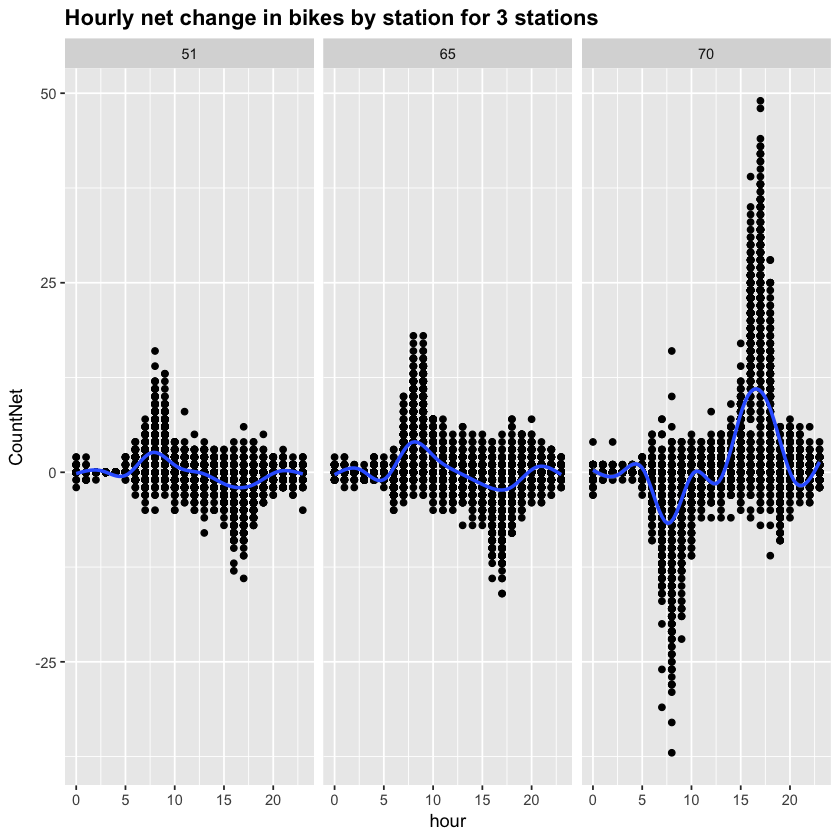

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”Warning message:
“Computation failed in `stat_smooth()`:
x has insufficient unique values to support 10 knots: reduce k.”

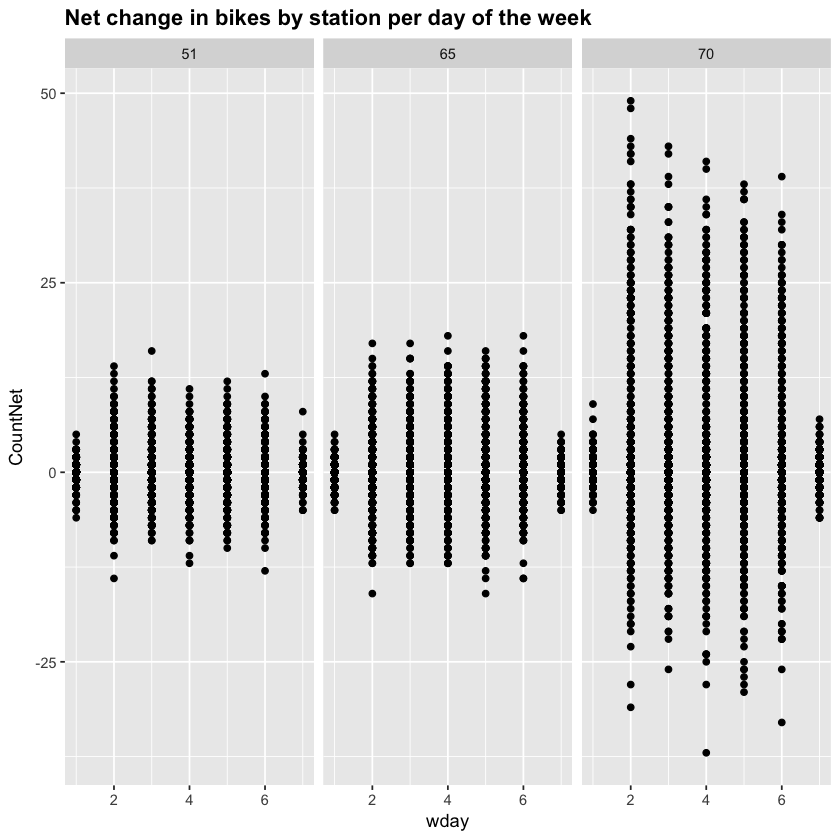

In [7]:
HourlyPlot={ggplot(subset(DFall, `Station` %in% c(51, 65, 70)), aes_string(x="hour", y="CountNet")) +
    geom_point()  +
    ggtitle("Hourly net change in bikes by station for 3 stations")  +
    theme(plot.title = element_text(lineheight=.8, face="bold"))+facet_wrap(~Station)+geom_smooth(method="auto")}
print(HourlyPlot)
ggsave(HourlyPlot,file="HourlyPlot.png",width=14,height=10,units="cm")
DayofWeek_Plot={ggplot(subset(DFall, `Station` %in% c(51, 65, 70)), aes_string(x="wday", y="CountNet")) +
    geom_point()  +
    ggtitle("Net change in bikes by station per day of the week")  +
    theme(plot.title = element_text(lineheight=.8, face="bold"))+facet_wrap(~Station)+geom_smooth(method="auto")}
print(DayofWeek_Plot)
ggsave(DayofWeek_Plot,file="DayofWeek_Plot.png",width=14,height=10,units="cm")

#### Trends in the data: influence of weather
Intuitively, the weather will strongly influence a person's choice to ride a bicycle versus find another mode of transportation. This is evident in the data as well. For the same 3 stations as shown above, ridership levels fall drastically with increased precipitation.

![Precip_Plot](Precip_Plot.png)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


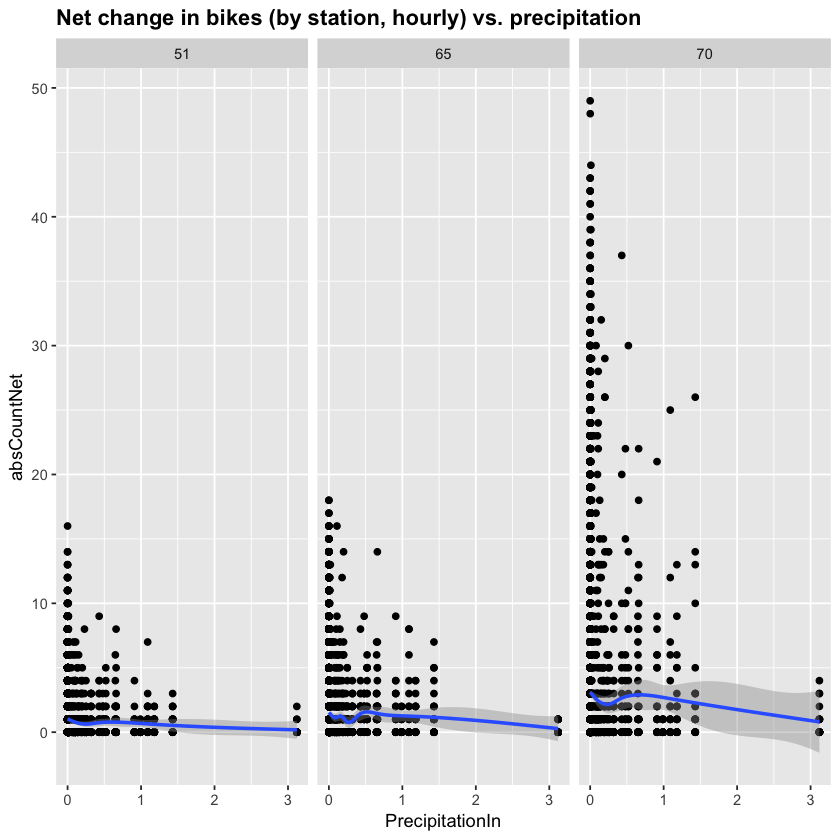

In [8]:
Precip_Plot={ggplot(subset(DFall, `Station` %in% c(51, 65, 70)), aes_string(x="PrecipitationIn", y="absCountNet")) +
    geom_point()  +
    ggtitle("Net change in bikes (by station, hourly) vs. precipitation")  +
    theme(plot.title = element_text(lineheight=.8, face="bold"))+facet_wrap(~Station)+geom_smooth(method="auto")}
print(Precip_Plot)
ggsave(Precip_Plot,file="Precip_Plot.png",width=14,height=10,units="cm")

## Modelling approach
#### Feature selection
To save computation time and simplify the model inputs, redundant features are removed by way of multicollinearity analysis. A correlation plot (below) shows that many features in the weather data predict one another. For instance, good correlation exists between most sets of max/mean/min values, so only the mean value was selected in cases where all 3 were provided.

corrplot 0.84 loaded


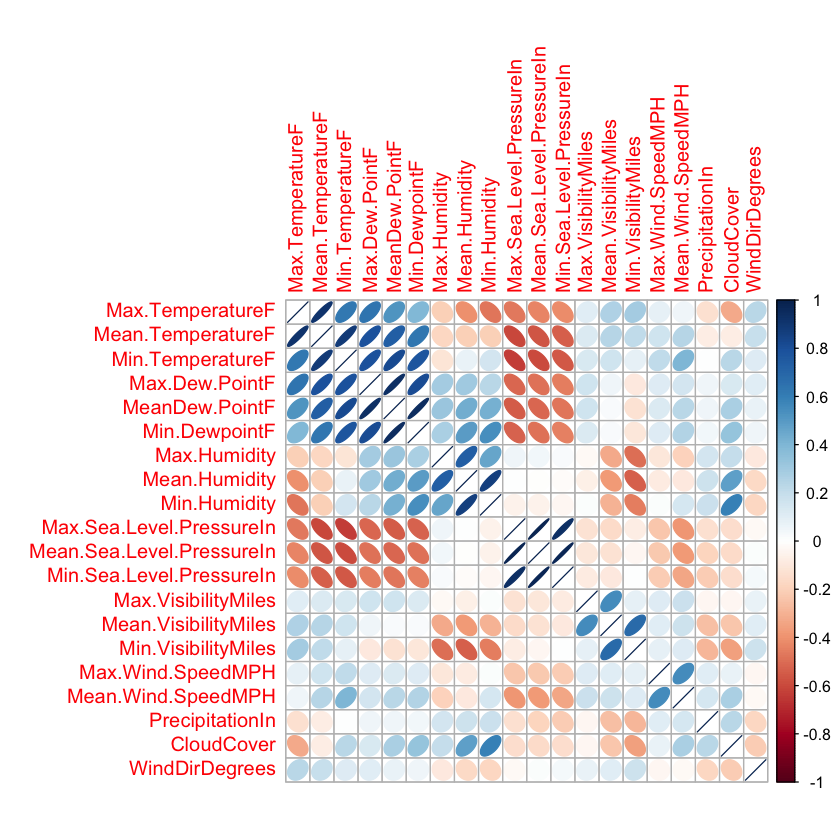

In [9]:
library(corrplot);
corrvars <- names(WD) %in% c("Zip","Date","Events")
WD_num<-WD[!corrvars]
WD_num<-WD_num[complete.cases(WD_num), ]

o=corrplot(cor(WD_num),method='ellipse')

#### Feature engineering
To prevent certain features from dominating the model due to their scales, the scale() function was used to standardize quantitative features by subtracting the mean value and dividing by the standard deviation.

Additionally, the cyclical data of time of day, day of week, and month present difficulties when used quantitatively in linear machine learning models. Because the bike share behavior is likely similar at 11:59pm and 12:01am, it is preferable to use one-hot encoding to extract these features and treat them as binary categories. For example, a column representing the month of January is 1 for dates falling within that month and 0 for dates outside that month. In the model, weights will be calculated for each of these new binary categories.

In [ ]:
#Create data frames for specific stations
DF_68 <- DFall[ which(DFall$Station== 68), ]
DF_68$CountNet_prev_hour<- c(NA, DF_68$CountNet[-nrow(DF_68)])
DF_68=DF_68[-1,]
DF_70 <- DFall[ which(DFall$Station== 70), ]
DF_70$CountNet_prev_hour<- c(NA, DF_70$CountNet[-nrow(DF_70)])
DF_70=DF_70[-1,]

#Feature scaling
myvars_to_scale <- names(DF_70) %in% c("PrecipitationIn", 
                              "Mean.TemperatureF", 
                              "MeanDew.PointF",
                              "Mean.Humidity",
                              "Mean.Sea.Level.PressureIn",
                              "Mean.VisibilityMiles",
                              "Mean.Wind.SpeedMPH",
                              "CloudCover",
                              "WindDirDegrees")#,
                             # "CountNet_prev_hour")

myvars_to_not_scale <- names(DF_70) %in% c( "CountNet",
                              "wday", 
                              "hour", 
                              "month") 

TDformodel <- scale(DF_70[myvars_to_scale])
TDformodel<-cbind(TDformodel,DF_70[myvars_to_not_scale])

#One-hot encoding of day of week, hour, and month features. 
#This could have been done faster with the dummyVars function from the caret package.
TDformodel$Sunday<-ifelse(TDformodel$wday==1, 1, 0)
TDformodel$Monday<-ifelse(TDformodel$wday==2, 1, 0)
TDformodel$Tuesday<-ifelse(TDformodel$wday==3, 1, 0)
TDformodel$Wednesday<-ifelse(TDformodel$wday==4, 1, 0)
TDformodel$Thursday<-ifelse(TDformodel$wday==5, 1, 0)
TDformodel$Friday<-ifelse(TDformodel$wday==6, 1, 0)
TDformodel$Saturday<-ifelse(TDformodel$wday==7, 1, 0)
TDformodel$wday=NULL

TDformodel$hr0<-ifelse(TDformodel$hour==0, 1, 0)
TDformodel$hr1<-ifelse(TDformodel$hour==1, 1, 0)
TDformodel$hr2<-ifelse(TDformodel$hour==2, 1, 0)
TDformodel$hr3<-ifelse(TDformodel$hour==3, 1, 0)
TDformodel$hr4<-ifelse(TDformodel$hour==4, 1, 0)
TDformodel$hr5<-ifelse(TDformodel$hour==5, 1, 0)
TDformodel$hr6<-ifelse(TDformodel$hour==6, 1, 0)
TDformodel$hr7<-ifelse(TDformodel$hour==7, 1, 0)
TDformodel$hr8<-ifelse(TDformodel$hour==8, 1, 0)
TDformodel$hr9<-ifelse(TDformodel$hour==9, 1, 0)
TDformodel$hr10<-ifelse(TDformodel$hour==10, 1, 0)
TDformodel$hr11<-ifelse(TDformodel$hour==11, 1, 0)
TDformodel$hr12<-ifelse(TDformodel$hour==12, 1, 0)
TDformodel$hr13<-ifelse(TDformodel$hour==13, 1, 0)
TDformodel$hr14<-ifelse(TDformodel$hour==14, 1, 0)
TDformodel$hr15<-ifelse(TDformodel$hour==15, 1, 0)
TDformodel$hr16<-ifelse(TDformodel$hour==16, 1, 0)
TDformodel$hr17<-ifelse(TDformodel$hour==17, 1, 0)
TDformodel$hr18<-ifelse(TDformodel$hour==18, 1, 0)
TDformodel$hr19<-ifelse(TDformodel$hour==19, 1, 0)
TDformodel$hr20<-ifelse(TDformodel$hour==20, 1, 0)
TDformodel$hr21<-ifelse(TDformodel$hour==21, 1, 0)
TDformodel$hr22<-ifelse(TDformodel$hour==22, 1, 0)
TDformodel$hr23<-ifelse(TDformodel$hour==23, 1, 0)
TDformodel$hour=NULL

TDformodel$January<-ifelse(TDformodel$month==1,1,0)
TDformodel$February<-ifelse(TDformodel$month==2,1,0)
TDformodel$March<-ifelse(TDformodel$month==3,1,0)
TDformodel$April<-ifelse(TDformodel$month==4,1,0)
TDformodel$May<-ifelse(TDformodel$month==5,1,0)
TDformodel$June<-ifelse(TDformodel$month==6,1,0)
TDformodel$July<-ifelse(TDformodel$month==7,1,0)
TDformodel$August<-ifelse(TDformodel$month==8,1,0)
TDformodel$September<-ifelse(TDformodel$month==9,1,0)
TDformodel$October<-ifelse(TDformodel$month==10,1,0)
TDformodel$November<-ifelse(TDformodel$month==11,1,0)
TDformodel$December<-ifelse(TDformodel$month==12,1,0)
TDformodel$month=NULL;

#### Model selection: Lasso regression
As a first analysis into the data, a lasso regression executed using glmnet was considered. Regularized linear regression models have low processing requirements and can quickly highlight important features in the data.

In [ ]:
#Partition the data into training and test samples
library(caret)
library(glmnet)

set.seed(123)
training.samples <- TDformodel$CountNet %>% createDataPartition(TDformodel$CountNet,times=2, p = 0.8, list = FALSE)
train.data  <- TDformodel[training.samples, ]
test.data <- TDformodel[-training.samples, ]

#Assign training and 
x <- model.matrix(CountNet~., train.data)[,-1]
y <- train.data$CountNet

performance=data.frame(alpha=double(),RMSE=double(), Rsquare=double())
  alpha=1 #0 for ridge, 1 for lasso 
  glmnet(x, y, alpha = alpha, lambda = NULL);
  # Find the best lambda using cross-validation
  set.seed(123) 
  cv <- cv.glmnet(x, y, alpha = alpha);
  # Display the best lambda value
  print(cv$lambda.min)
  
  # Fit the final model on the training data
  model <- glmnet(x, y, alpha = alpha, lambda = cv$lambda.min);
  #plot(model);
  # Display regression coefficients
  print(coef(model))
  
  # Make predictions on the test data
  x.test <- model.matrix(CountNet~., test.data)[,-1]
  predictions <- model %>% predict(x.test) %>% as.vector()
  # Model performance metrics
  performance=rbind(performance, data.frame(alpha=alpha,RMSE= RMSE(predictions, test.data$CountNet),R2=R2(predictions, test.data$CountNet)))
print(performance)
  plot(cv)


#### Performance analysis: lasso regression
For station 70, the root mean square error of the model on the test data was 4.12 compared to the training data error of roughly 4.5 (taken from the cross validation plot). Superficially these errors seem similar, indicating similar levels of error between the training and test sets; however, the R^2 value of 0.63 is poor, indicating the linear model does not fit any of the training or test data very well. Nonetheless, the regression coefficients do capture some features in the data. For instance, the time periods of 7-9am and 3-6pm are appropriately weighted for the rush hour behavior of station 70.

#### Model selection: random forest
Overall, the regularized linear regression model above was not a good fit for this data, implying there may be nonlinear interactions between the features. An improved approach is the random forests model, which handles interactions better. However, this comes at the expense of computation time.

In [ ]:
library(e1071)
fitControl <- trainControl(## 10-fold CV
  method = "repeatedcv",
  number = 10,
  ## repeated ten times
  repeats = 1)

RF <- train(CountNet ~ ., data = train.data, 
                   method = "ranger", 
                   trControl = fitControl)
RF

#### Performance analysis: random forest
Because of the long computation time of the random forest model above, a copy of the model fit performance to the training and test data is shown below. The fit to the training data shows an RMSE of 0.81 and R^2 of 0.98. The fit to the test data is 0.84 with an RMSE of 2.77. The RMSE and R^2 show that the fit to the training data is better than the test data, implying that the model is somewhat overfit to the training data and could be simplified. However, the performance of the model on the test data is acceptably good. The random forest model performance greatly exceeds that of the linear regression.

In [ ]:
> trainPred <- predict(RF, train.data)
> postResample(trainPred, train.data$CountNet)
     RMSE  Rsquared       MAE 
0.8114849 0.9864434 0.3879575 

> View(test.data)
> testPred<-predict(RF,test.data)
> postResample(testPred,test.data$CountNet)
     RMSE  Rsquared       MAE 
2.7685379 0.8358032 1.5633028 

## Conclusions
The bike share data contains a wealth of interesting relationships. The influence of time of day, day of the week, and weather affects each station differently according to its geographic location. Using careful feature selection and engineering, two modelling approaches were used: regularized linear regression and random forest. The linear regression model showed poor fit to the data, meaning that some nonlinear feature interactions were present. The random forest model performed much better at the expense of computation time.


## Potential improvements
The most important drawback of the random forest modelling approach is computation time. It is evident from the exploratory data analysis that some features affect the entire network in a similar way (e.g., precipitation) whereas certain features only affect individual stations (e.g., time of day). A multi-step approach to the model could separate out these effects, meaning fewer features would be needed for the station-by-station modelling approach used here. Additionally, other  could be considered including neural networks to better fit the complex interactions in the data.